<a target="_blank" href="https://colab.research.google.com/github/markusmeister/MIB-Public/blob/master/python/Figures_Ch_3.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Ch 3 - Linear Systems

This notebook contains python code for generating figures in Chapter 3 of the book _Mathematics in Biology_.

## Imports and utilities

In [1]:
import numpy as np
from pathlib import Path
import matplotlib
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit

# set font to be used in figures
import matplotlib.font_manager as font_manager
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'serif';
cmfont = font_manager.FontProperties(fname=matplotlib.get_data_path() + '/fonts/ttf/cmr10.ttf');
matplotlib.rcParams['font.serif']=cmfont.get_name();
matplotlib.rcParams['axes.formatter.use_mathtext'] = True
matplotlib.rcParams['axes.unicode_minus']=False
matplotlib.rcParams['font.size'] = 11

data_url = 'https://raw.githubusercontent.com/markusmeister/MIB-Public/master/data/'

Save = False # set to True if you are saving figures to a local drive
if Save:
    # set path to save the figures
    savedir = Path('../img')
    savedir.mkdir(parents=True, exist_ok=True)

In [2]:
# Utilities for plotting

def plot(X, Y=None, xlabel=None, ylabel=None, legend=[], loc=None, title=None, alpha=1.0,
         xlim=None, ylim=None, xscale='linear', yscale='linear',
         xticks=None, yticks=None, xhide=False, yhide=False, yrot=False,
         xzero=False, yzero=False, yflip=False,
         fmts=['r-','g-','b-','y-','c-','m-'], linewidth=2, markersize=5, fillstyle='full',
         markeredgewidth=1, rasterized=False,
         grid=False, equal=False, figsize=(5,3), axes=None):
    """
    Plot data points.
    X: an array or list of arrays
    Y: an array or list of arrays
    If Y exists then those values are plotted vs the X values
    If Y doesn't exist the X values are plotted
    xlabel, ylabel: axis labels
    legend: list of labels for each Y series
    loc: location of the legend, like 'upper right'
    title: duh
    xlim, ylim: [low,high] list of limits for the 2 axes
    xscale, yscale: 'linear' or 'log'
    xticks, yticks: list of locations for tick marks, or None for auto ticks
    yhide: hide the y axis?
    yrot: rotate the yaxis label to horizontal?
    yzero: zero line for the y-axis?
    fmts: a list of format strings to be applied to successive Y-series
    linewidth, markersize, fillstyle, markeredgewidth: see docs
    grid: draw a grid?
    equal: use equal aspect ratio, i.e. same scale per unit on x and y axis?
    figsize: (h,v) in inches
    rasterized: rasterize the data portion of the graph?
    axes: pre-existing axes where to draw the plot
    Returns: axes for the plot
    """

    if not axes: # start a new figure
        fig = plt.figure(figsize=figsize)
        axes = plt.gca()

    def has_one_axis(X): # Return True if X (ndarray or list) has 1 axis
        return (hasattr(X, "ndim") and X.ndim == 1 or isinstance(X, list)
                and not hasattr(X[0], "__len__"))

    if has_one_axis(X):
        X = [X]
    if Y is None:
        X, Y = [[]] * len(X), X
    elif has_one_axis(Y):
        Y = [Y]
    if len(X) != len(Y):
        X = X * len(Y)
    # axes.cla() # clears these axes
    for x, y, fmt in zip(X, Y, fmts):
        if len(x):
            axes.plot(x, y, fmt, linewidth=linewidth, markersize=markersize,
            	fillstyle=fillstyle,markeredgewidth=markeredgewidth,
            	rasterized=rasterized, alpha=alpha)
        else:
            axes.plot(y, fmt, linewidth=linewidth, markersize=markersize,
            	fillstyle=fillstyle,markeredgewidth=markeredgewidth,
            	rasterized=rasterized, alpha=alpha)
    set_axes(axes, xlabel, ylabel, legend, loc, xlim, ylim, xscale, yscale,
             xticks, yticks, xhide, yhide, yrot, xzero, yzero, yflip, grid, equal)
    if title:
        plt.title(title)
    plt.tight_layout()

    return axes # useful if we started a new figure

def hist(X, bins=50, range=None, density=None, weights=None, histtype='stepfilled', stacked=False,
         align='mid', color=['r','g','b','m'], alpha=0.5, linewidth=1,
         xlabel=None, ylabel=None, legend=[], loc=None, title=None,
         xlim=None, ylim=None, xscale='linear', yscale='linear',
         xticks=None, yticks=None, xhide=False, yhide=False, yrot=False,
         xzero=False, yzero=False, yflip=False,
         grid=False, figsize=(5,3), axes=None, orientation='vertical'):
    """
    Histogram data.
    X: an array or list of arrays to be histogrammed
    bins: the number of bins, or a list of edges
    range: [low,high] the range over which the bins are spread
    density: normalize to unit area?
    weights: array same shape as X; each value in X only contributes that weight.
    histtype: 'bar','barstacked','step','stepfilled'
    stacked: plot multiple series on top of each other?
    align: 'left','mid',right', center the bar on left edge, center, or right edge of bin
    color: list of colors for the data series
    alpha: opacity, useful if histtype='stepfilled'
    xlabel, ylabel: axis labels
    legend: list of labels for each Y series
    loc: location of the legend, like 'upper right'
    title: duh
    xlim, ylim: [low,high] list of limits for the 2 axes
    xscale, yscale: 'linear' or 'log'
    xticks, yticks: list of locations for tick marks, or None for auto ticks
    yhide: hide the y axis?
    yrot: rotate the yaxis label to horizontal?
    yzero: zero line for the y-axis?
    grid: draw a grid?
    figsize: (h,v) in inches
    axes: pre-existing axes where to draw the plot
    Returns: axes, n, bins, patches
    """

    if not axes: # start a new figure
        fig,ax = plt.subplots(figsize=figsize)
    else:
    	ax=axes

    def has_one_axis(X): # Return True if X (ndarray or list) has 1 axis
        return (hasattr(X, "ndim") and X.ndim == 1 or isinstance(X, list)
                and not hasattr(X[0], "__len__"))

    if has_one_axis(X):
        ndata=1
    else:
        ndata=len(X) # assuming it is an ndarray or a list of lists

    if len(color)<ndata: # if there aren't enough dolors provided
        col=None # use the default color sequence
    else:
        col=color[:ndata]

    if histtype=='step' or histtype=='stepfilled': # in these cases the legend sequence needs to be inverted for some reason
        if isinstance(legend, list):
        	legend = legend[-1::-1]

    n, bins, patches = ax.hist(X, bins=bins, range=range, density=density, weights=weights,
                                 histtype=histtype, stacked=stacked, align=align,
                                 color=col, alpha=alpha, linewidth=linewidth,
                                 label=legend, orientation=orientation)

    set_axes(ax, xlabel, ylabel, legend, loc, xlim, ylim, xscale, yscale,
    	xticks, yticks, xhide, yhide, yrot, xzero, yzero, yflip, grid, equal=False)

    if title:
        plt.title(title)
    if not axes:
    	plt.tight_layout() # otherwise let the caller take care of layout

    return ax, n, bins, patches # useful if we started a new figure

def set_axes(axes, xlabel, ylabel, legend, loc, xlim, ylim, xscale, yscale,
    	xticks, yticks, xhide, yhide, yrot, xzero, yzero, yflip, grid, equal):
    """Set the axes for matplotlib."""
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    if xlim:
        axes.set_xlim(xlim)
    else:
        axes.set_xlim(auto=True)
    if ylim:
        axes.set_ylim(ylim)
    else:
        axes.set_ylim(auto=True)
    if grid:
        axes.grid()
    if equal:
        axes.set_aspect(aspect='equal')
    if ylabel:
        if yrot:
            axes.set_ylabel(ylabel, fontsize=12, rotation=0, labelpad=15)
        else:
            axes.set_ylabel(ylabel, fontsize=12)
    if xlabel:
        axes.set_xlabel(xlabel, fontsize=12)
    axes.get_yaxis().set_visible(not yhide)
    axes.get_xaxis().set_visible(not xhide)
    if xzero:
        axes.axvline(color='black', linewidth=0.5)
    if yzero:
        axes.axhline(color='black', linewidth=0.5)
    if yflip:
        axes.invert_yaxis()
    axes.tick_params(axis = 'both', which = 'major', labelsize = 10)
    axes.tick_params(axis = 'both', which = 'minor', labelsize = 9)
    if xticks != None:
        axes.set_xticks(xticks); # no minor ticks
    if yticks != None:
        axes.set_yticks(yticks); # no minor ticks
    if legend:
        axes.legend(legend, loc=loc)
    plt.draw()
    #     To change the font and control the fontsize, can use some of these commands:
    #     axes.set_xlabel(xlabel, fontname='Arial', fontsize = 12)
    #     axes.set_ylabel(ylabel, fontname='Arial', fontsize = 12)
    #     axes.tick_params(axis = 'both', which = 'major', labelsize = 10)
    #     axes.tick_params(axis = 'both', which = 'minor', labelsize = 9)
    #     plt.yticks(fontname = "Arial")
    #     plt.xticks(fontname = "Arial")
    #     if legend:
    #         axes.legend(legend, prop={"size":12, "family":'Arial'})
    #     For options on legend placement see https://stackoverflow.com/questions/4700614/how-to-put-the-legend-out-of-the-plot

def test_plot():
    x = np.arange(-10,10,.01)
    t = [0.1,0.3,1,3,10]
    y = [np.exp(-x**2/(4*ti))/np.sqrt(4*np.pi*ti) for ti in t]
    plot (x,y,fmts=['r-','g-','b-','y-','c-','m-'],linewidth=1,
        xlabel='Distance',ylabel='Concentration',yzero=True,
        legend=['t=0.1','0.3','1','3','10'],xticks=[-10,-5,-1,0,1,5,10])

# Linear Systems

## Convolution

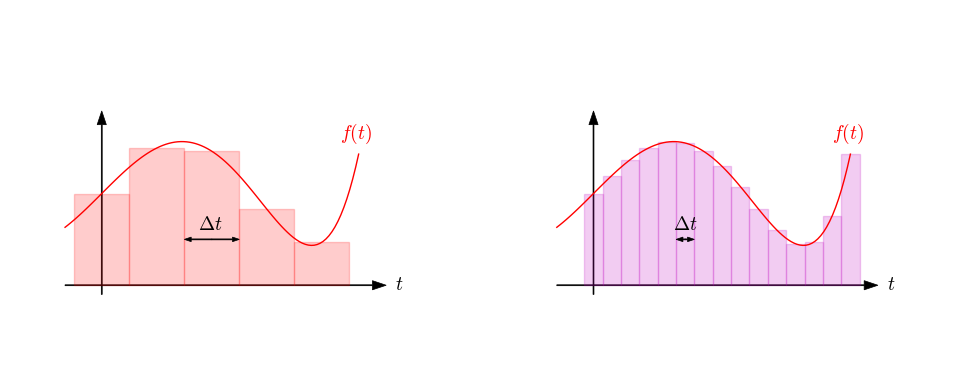

In [3]:
from matplotlib.patches import Rectangle, Arc

fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(10,4))

ax0.arrow(-0.4,0,3.5,0,width=0.01,length_includes_head=True,head_width=0.1,
                overhang=0,color='k',linewidth=0.5)
ax0.text(3.2,-0.05 ,r'$t$',fontsize=14,color='k')
ax0.arrow(0,-0.1,0,2,width=0.01,length_includes_head=True,head_width=0.1,
                overhang=0,color='k',linewidth=0.5)

x = np.linspace(-0.4,2.8,100)
y=1+x-0.5*x**3+0.05*x**5
ax0.plot(x,y,'r',linewidth=1)
ax0.text(2.6,1.6 ,r'$f(t)$',fontsize=14,color='r')

ax0.set_xlim(-1,4)
ax0.set_aspect('equal')
ax0.axis('off')
ax0.set_ylim(-1,3)

k=5
for i in range(k):
    thisX=i*3/k
    thisY=1+thisX-0.5*thisX**3+0.05*thisX**5
    ax0.add_patch(Rectangle((thisX-3/(2*k), 0), 3/k, thisY,edgecolor='r',facecolor='r',alpha=0.2))
    if i==2:
        ax0.arrow(thisX,0.5,3/(2*k),0,width=0.01,length_includes_head=True,head_width=0.05,
                overhang=0,color='k',linewidth=0.5)
        ax0.arrow(thisX,0.5,-3/(2*k),0,width=0.01,length_includes_head=True,head_width=0.05,
                overhang=0,color='k',linewidth=0.5)
        ax0.text(thisX-3/(4*k),0.6 ,r'$\Delta t$',fontsize=14,color='k')

ax1.arrow(-0.4,0,3.5,0,width=0.01,length_includes_head=True,head_width=0.1,
          overhang=0,color='k',linewidth=0.5)
ax1.text(3.2,-0.05 ,r'$t$',fontsize=14,color='k')
ax1.arrow(0,-0.1,0,2,width=0.01,length_includes_head=True,head_width=0.1,
                overhang=0,color='k',linewidth=0.5)

x = np.linspace(-0.4,2.8,100)
y=1+x-0.5*x**3+0.05*x**5
ax1.plot(x,y,'r',linewidth=1)
ax1.text(2.6,1.6 ,r'$f(t)$',fontsize=14,color='r')

ax1.set_xlim(-1,4)
ax1.set_aspect('equal')
ax1.axis('off')
ax1.set_ylim(-1,3)

k=15
for i in range(k):
    thisX=i*3/k
    thisY=1+thisX-0.5*thisX**3+0.05*thisX**5
    ax1.add_patch(Rectangle((thisX-3/(2*k), 0), 3/k, thisY,edgecolor='m',facecolor='m',alpha=0.2))
    if i==5:
        ax1.arrow(thisX,0.5,3/(2*k),0,width=0.01,length_includes_head=True,head_width=0.05,
                overhang=0,color='k',linewidth=0.5)
        ax1.arrow(thisX,0.5,-3/(2*k),0,width=0.01,length_includes_head=True,head_width=0.05,
                overhang=0,color='k',linewidth=0.5)
        ax1.text(thisX-4/(2*k),0.6 ,r'$\Delta t$',fontsize=14,color='k')

fig.tight_layout()
if Save:
    fig.savefig(str(savedir / 'ch_LinSys_PulseApprox.pdf'), dpi=600, format='pdf', bbox_inches='tight');

## Concepts

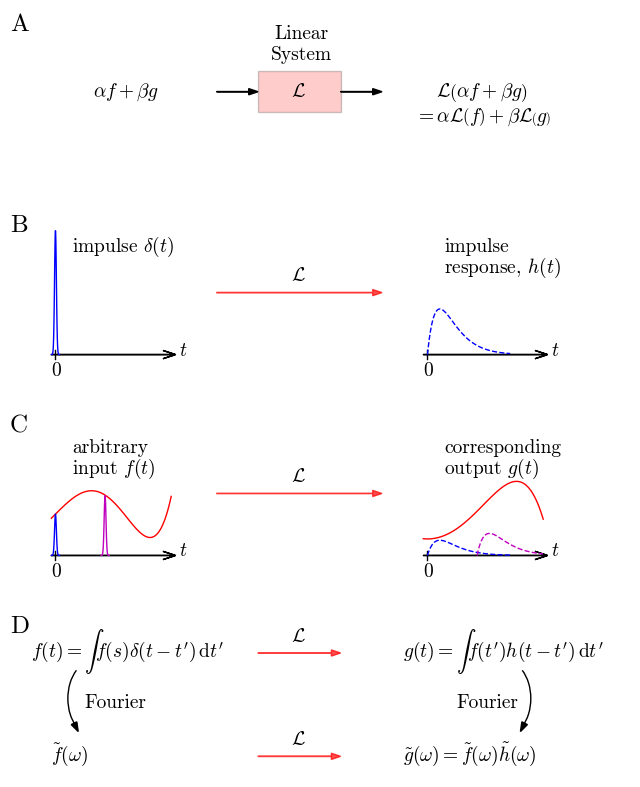

In [4]:
from matplotlib.patches import Rectangle, Arc

fig, (ax0, ax1, ax2, ax3) = plt.subplots(nrows=4, ncols=1, figsize=(8,10))

ax0.text(2,1.9 ,r'$\alpha f + \beta g$',fontsize=14,color='k')

ax0.text(0,3.5,r'A',fontsize=18,color='k')
ax0.arrow(5,2,1,0,width=0.01,length_includes_head=True,head_width=0.15,
                overhang=0,color='k')
ax0.add_patch(Rectangle((6, 1.5), 2, 1,edgecolor='k',facecolor='r',alpha=0.2))
ax0.arrow(8,2,1,0,width=0.01,length_includes_head=True,head_width=0.15,
                overhang=0,color='k')
ax0.text(6.4,3.3 ,r'Linear',fontsize=14,color='k')
ax0.text(6.3,2.8 ,r'System',fontsize=14,color='k')
ax0.text(6.8,1.9 ,r'$\mathcal{L}$',fontsize=14,color='k')
ax0.text(10.3,1.9 ,r'$\mathcal{L}\left( \alpha f + \beta g\right)$',fontsize=14,color='k')
ax0.text(9.8,1.3 ,r'$= \alpha\mathcal{L}\left(f\right) + \beta\mathcal{L}\left( g\right)$',fontsize=14,color='k')

ax0.set_xlim(0,15)
ax0.set_aspect('equal')
ax0.axis('off')
ax0.set_ylim(0,4)

ax1.text(0,3.5,r'B',fontsize=18,color='k')
ax1.arrow(5,2,4,0,width=0.01,length_includes_head=True,head_width=0.15,
                overhang=0,color='r',alpha=0.7)
ax1.text(6.8,2.3 ,r'$\mathcal{L}$',fontsize=14,color='k')
ax1.arrow(1,0.5,3,0,width=0.01,length_includes_head=True,head_width=0.2,
                overhang=1,color='k')
ax1.text(4.1,0.5 ,r'$t$',fontsize=14,color='k')
ax1.arrow(10,0.5,3,0,width=0.01,length_includes_head=True,head_width=0.2,
                overhang=1,color='k')
ax1.text(13.1,0.5 ,r'$t$',fontsize=14,color='k')
ax1.plot([1.1,1.1],[0.4,0.6],'k',linewidth=1)
ax1.text(1.0,0 ,r'$0$',fontsize=14,color='k')
ax1.plot([10.1,10.1],[0.4,0.6],'k',linewidth=1)
ax1.text(10.0,0 ,r'$0$',fontsize=14,color='k')

x = np.linspace(-0.1,0.1,100)
y=3*np.exp(-x**2/0.001)
ax1.plot(x+1.1,y+0.5,'b',linewidth=1)
ax1.text(1.5,3 ,'impulse $\delta(t)$',fontsize=14,color='k')

x = np.linspace(0,2,100)
y=10*np.exp(-x/0.3)*x
ax1.plot(x+10.1,y+0.5,'b',linewidth=1,linestyle='dashed')
ax1.text(10.5,3 ,'impulse',fontsize=14,color='k')
ax1.text(10.5,2.5 ,'response, $h(t)$',fontsize=14,color='k')

ax1.set_xlim(0,15)
ax1.set_aspect('equal')
ax1.axis('off')
ax1.set_ylim(0,4)


ax2.text(0,3.5,r'C',fontsize=18,color='k')
ax2.arrow(5,2,4,0,width=0.01,length_includes_head=True,head_width=0.15,
                overhang=0,color='r',alpha=0.7)
ax2.text(6.8,2.3 ,r'$\mathcal{L}$',fontsize=14,color='k')
ax2.arrow(1,0.5,3,0,width=0.01,length_includes_head=True,head_width=0.2,
                overhang=1,color='k')
ax2.text(4.1,0.5 ,r'$t$',fontsize=14,color='k')
ax2.arrow(10,0.5,3,0,width=0.01,length_includes_head=True,head_width=0.2,
                overhang=1,color='k')
ax2.text(13.1,0.5 ,r'$t$',fontsize=14,color='k')
ax2.plot([1.1,1.1],[0.4,0.6],'k',linewidth=1)
ax2.text(1.0,0 ,r'$0$',fontsize=14,color='k')
ax2.plot([10.1,10.1],[0.4,0.6],'k',linewidth=1)
ax2.text(10.0,0 ,r'$0$',fontsize=14,color='k')

x = np.linspace(-0.1,2.8,100)
y=1+x-0.5*x**3+0.05*x**5
ax2.plot(x+1.1,y+0.5,'r',linewidth=1)
ax2.text(1.5,3 ,'arbitrary',fontsize=14,color='k')
ax2.text(1.5,2.5 ,'input $f(t)$',fontsize=14,color='k')

ax2.text(10.5,3 ,'corresponding',fontsize=14,color='k')
ax2.text(10.5,2.5 ,'output $g(t)$',fontsize=14,color='k')

x = np.linspace(-0.1,0.1,100)
y=1.0*np.exp(-x**2/0.001)
ax2.plot(x+1.1,y+0.5,'b',linewidth=1)
ax2.plot(x+2.3,1.45*y+0.5,'m',linewidth=1)

x = np.linspace(0,2,100)
y=10*np.exp(-x/0.3)*x
ax2.plot(x+10.1,y/3+0.5,'b',linewidth=1,linestyle='dashed')
ax2.plot(x[:80]+11.3,1.45*y[:80]/3+0.5,'m',linewidth=1,linestyle='dashed')

x = np.linspace(-0.1,2.8,100)
y=0.4+0.5*x**2-0.02*x**5
ax2.plot(x+10.1,(y+0.5),'r',linewidth=1)

ax2.set_xlim(0,15)
ax2.set_aspect('equal')
ax2.axis('off')
ax2.set_ylim(0,4)


ax3.text(0.5,2.9 ,'$f(t)=\int f(s)\delta(t-t^\prime) \, {\mathrm{d}}t^\prime$',fontsize=14,color='k')
ax3.text(1,0.4 ,'$\\tilde{f}(\omega)$',fontsize=14,color='k')
ax3.text(9.5,2.9 ,'$g(t)=\int f(t^\prime) h(t-t^\prime) \, {\mathrm{d}}t^\prime$',fontsize=14,color='k')
ax3.text(9.5,0.4 ,'$\\tilde{g}(\omega)=\\tilde{f}(\omega)\\tilde{h}(\omega)$',fontsize=14,color='k')
ax3.text(0,3.5,r'D',fontsize=18,color='k')
ax3.arrow(6,0.5,2,0,width=0.01,length_includes_head=True,head_width=0.15,
                overhang=0,color='r',alpha=0.7)
ax3.arrow(6,3,2,0,width=0.01,length_includes_head=True,head_width=0.15,
                overhang=0,color='r',alpha=0.7)
ax3.text(6.8,3.3 ,r'$\mathcal{L}$',fontsize=14,color='k')
ax3.text(6.8,0.8 ,r'$\mathcal{L}$',fontsize=14,color='k')

ax3.add_patch(Arc((2,1.9), 1.2, 1.8, angle=0.0, theta1=120, theta2=240,edgecolor='k'))
ax3.arrow(1.55,1.3,0.1,-0.20,width=0.01,length_includes_head=True,head_width=0.15,
                overhang=0,color='k')
ax3.text(1.8,1.7 ,'Fourier',fontsize=14,color='k')

ax3.add_patch(Arc((12,1.9), 1.2, 1.8, angle=0.0, theta1=300, theta2=60,edgecolor='k'))
ax3.arrow(12.45,1.3,-0.1,-0.20,width=0.01,length_includes_head=True,head_width=0.15,
                overhang=0,color='k')
ax3.text(10.8,1.7 ,'Fourier',fontsize=14,color='k')

ax3.set_xlim(0,15)
ax3.set_aspect('equal')
ax3.axis('off')
ax3.set_ylim(0,4)

#fig.tight_layout()
if Save:
    fig.savefig(str(savedir / 'ch_LinSys_Concepts.pdf'), dpi=600, format='pdf', bbox_inches='tight');

## Fourier transforms

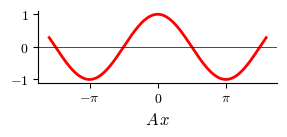

In [5]:
x = np.arange(-5, 5, 0.001)
y = np.cos(x)
fig, ax = plt.subplots(figsize=(3,1.5))
plot(x, y, xlabel='$A \, x$', yzero=True, axes=ax)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks([-np.pi, 0, np.pi])
ax.set_xticklabels(['$-\pi$', '$0$', '$\pi$'])
if Save:
    fig.savefig(str(savedir / 'ft_cos.pdf'), dpi=600, format='pdf', bbox_inches='tight');

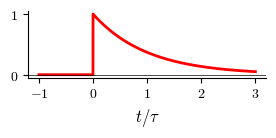

In [6]:
x = np.arange(-1, 3, 0.001)
y = np.exp(-x)
y[x<0]=0
fig, ax = plt.subplots(figsize=(3,1.5))
plot(x, y,xlabel=r'$t / \tau$', yzero=True, axes=ax);
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
if Save:
    fig.savefig(str(savedir / 'ft_exp.pdf'), dpi=600, format='pdf', bbox_inches='tight');

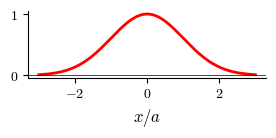

In [7]:
x = np.arange(-3, 3, 0.001)
y = np.exp(-x**2/2)
fig, ax = plt.subplots(figsize=(3,1.5))
plot(x, y, xlabel='$x/a$', yzero=True, axes=ax);
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
if Save:
    fig.savefig(str(savedir / 'ft_gaussian.pdf'), dpi=600, format='pdf', bbox_inches='tight');

## The power spectrum of a signal

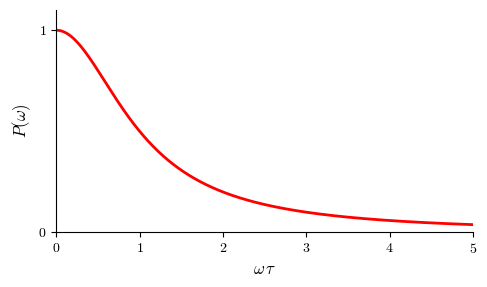

In [8]:
x = np.arange(0, 5, 0.001)
y = 1.0/(1+x**2)
fig, ax = plt.subplots(figsize=(5,3))
plot(x, y, xlabel=r'$\omega\,\tau$', xlim=(0,5), ylim=(0,1.1),
     ylabel=r'$P(\omega)$', yticks=[0,1], axes=ax);
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
if Save:
    fig.savefig(str(savedir / 'power_spectrum.pdf'), dpi=600, format='pdf', bbox_inches='tight');

## The Fourier Series

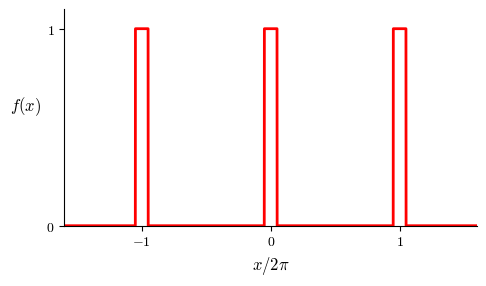

In [9]:
c = 0.314
x = np.arange(-1.6, 1.6, 0.001)
y = np.abs(x-np.round(x))<c/2/np.pi
fig, ax = plt.subplots(figsize=(5,3))
plot(x, y, xlabel=r'$x/2\pi$', xlim=(-1.6,1.6), ylim=(0,1.1),
     ylabel=r'$f(x)$', xticks=[-1,0,1], yticks=[0,1], yrot=True, axes=ax);
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
if Save:
    fig.savefig(str(savedir / 'img_per_pulse.pdf'), dpi=600, format='pdf', bbox_inches='tight');

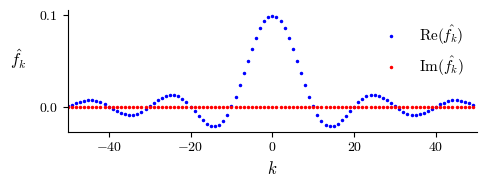

In [10]:
x = np.arange(-50.001, 49.999, 1) # to avoid the divide by zero
re = np.sin(x*c)/x/np.pi
im = x>100
fig, ax = plt.subplots(figsize=(5,2))
plot(x, [re,im], xlabel=r'$k$', ylabel=r'$\hat{f_k}$', yrot=True,
     xlim=(-50,50), yticks=[0,.1], markersize=3, fmts=['b.','r.'],
     legend=[r'$\mathrm{Re}(\hat{f_k})$',r'$\mathrm{Im}(\hat{f_k})$'], axes=ax);

ax.legend_.set_frame_on(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
if Save:
    fig.savefig(str(savedir / 'img_per_pulse_fs.pdf'), dpi=600, format='pdf', bbox_inches='tight');

## The Discrete Fourier Transform

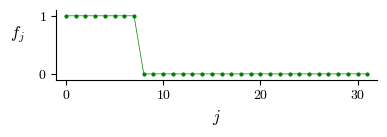

In [11]:
x = np.arange(0,32,1)
y = (x<8).astype(float)
fig, ax = plt.subplots(figsize=(4,1.5))
plot(x, y, xlabel=r'$j$', ylabel=r'$f_j$', yrot=True, xlim=(-1,32), ylim=(-.1,1.1),
     markersize=4, fmts=['g.-'], linewidth=0.5, yticks=[0,1], xticks=[0,10,20,30], axes=ax);

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
if Save:
    fig.savefig(str(savedir / 'img_dft_fj.pdf'), dpi=600, format='pdf', bbox_inches='tight');

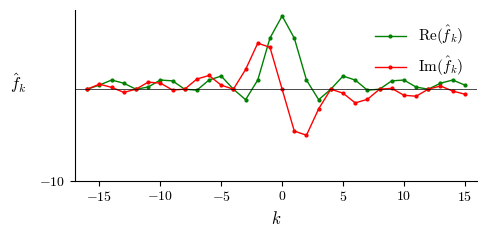

In [12]:
n = 32
m = 8
x = np.arange(-16+.001,16+.001,1) # to avoid singularity at 0
y = (1-np.exp(-2*np.pi*1j*x*m/n))/(1-np.exp(-2*np.pi*1j*x/n))
fig, ax = plt.subplots(figsize=(5,2.5))
legend=[r'$\mathrm{Re}(\hat{f}_k)$',r'$\mathrm{Im}(\hat{f}_k)$']
plot(x, [np.real(y),np.imag(y)], 
     xlabel=r'$k$', ylabel=r'$\hat{f}_k$', 
     xlim=(-17,16), markersize=4, fmts=['g.-','r.-'], linewidth=1, 
     yticks=[-10], yrot=True, yzero=True, axes=ax);
fig.tight_layout()
ax.legend(legend, loc='upper right')
ax.legend_.set_frame_on(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
if Save:
    fig.savefig(str(savedir / 'img_dft_fk.pdf'), dpi=600, format='pdf', bbox_inches='tight');

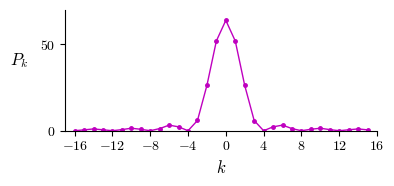

In [13]:
n = 32
m = 8
x = np.arange(-16+.001,16+.001,1) # to avoid singularity at 0
y = np.abs((1-np.exp(-2*np.pi*1j*x*m/n))/(1-np.exp(-2*np.pi*1j*x/n)))**2
fig, ax = plt.subplots(figsize=(4,2))
plot(x, y, xlabel=r'$k$', ylabel=r'$P_k$', 
          xlim=(-17,16), ylim=(0,70), markersize=5, fmts=['m.-'], linewidth=1, 
          yticks=[0,50], yrot=True, axes=ax);
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks(np.arange(-16,20,4))
if Save:
    fig.savefig(str(savedir / 'img_dft_pk.pdf'), dpi=600, format='pdf', bbox_inches='tight');

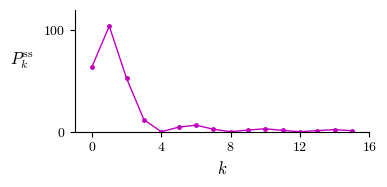

In [14]:
x1 = x[16:]
y1 = y[16:]*2
y1[0] /= 2
fig, ax = plt.subplots(figsize=(4,2))
plot(x1, y1, xlabel=r'$k$', ylabel=r'$P_k^{\rm{ss}}$', 
    xlim=(-1,16), ylim=(0,120), markersize=5, fmts=['m.-'], linewidth=1, 
    xticks=list(range(0,20,4)), yticks=[0,100], yrot=True, axes=ax);
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
if Save:
    fig.savefig(str(savedir / 'img_dft_pssk.pdf'), dpi=600, format='pdf', bbox_inches='tight');